In [1]:
import pprint
from features import features
import numpy as np

print('Total number of features:', len(features))
pp = pprint.PrettyPrinter(width=80, compact=True)
pp.pprint(features)

Total number of features: 155
['frame.interface_id', 'frame.dlt', 'frame.offset_shift', 'frame.time_epoch',
 'frame.time_delta', 'frame.time_delta_displayed', 'frame.time_relative',
 'frame.len', 'frame.cap_len', 'frame.marked', 'frame.ignored',
 'radiotap.version', 'radiotap.pad', 'radiotap.length', 'radiotap.present.tsft',
 'radiotap.present.flags', 'radiotap.present.rate', 'radiotap.present.channel',
 'radiotap.present.fhss', 'radiotap.present.dbm_antsignal',
 'radiotap.present.dbm_antnoise', 'radiotap.present.lock_quality',
 'radiotap.present.tx_attenuation', 'radiotap.present.db_tx_attenuation',
 'radiotap.present.dbm_tx_power', 'radiotap.present.antenna',
 'radiotap.present.db_antsignal', 'radiotap.present.db_antnoise',
 'radiotap.present.rxflags', 'radiotap.present.xchannel',
 'radiotap.present.mcs', 'radiotap.present.ampdu', 'radiotap.present.vht',
 'radiotap.present.reserved', 'radiotap.present.rtap_ns',
 'radiotap.present.vendor_ns', 'radiotap.present.ext', 'radiotap.mactime'

In [2]:
import pandas as pd
# get the training set
awid_train = pd.read_csv("/media/auro/RAID 5/networking/AWID/DATASET/AWID-CLS-R-Trn/1", header=None, names=features)
print('Data shape', awid_train.shape)
print(awid_train.head())

# see the distribution of the classes, high imbalance between normal and attack classes
print(awid_train['class'].value_counts(normalize=True))

/home/auro/PycharmProjects/IDS/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,74,88) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Data shape (1795575, 155)
   frame.interface_id frame.dlt  frame.offset_shift  frame.time_epoch  \
0                   0         ?                 0.0      1.393661e+09   
1                   0         ?                 0.0      1.393661e+09   
2                   0         ?                 0.0      1.393661e+09   
3                   0         ?                 0.0      1.393661e+09   
4                   0         ?                 0.0      1.393661e+09   

   frame.time_delta  frame.time_delta_displayed  frame.time_relative  \
0          0.000000                    0.000000             0.000000   
1          0.024271                    0.024271             0.024271   
2          0.001631                    0.001631             0.025902   
3          0.055325                    0.055325             0.081227   
4          0.000415                    0.000415             0.081642   

   frame.len  frame.cap_len  frame.marked  ...  wlan.qos.priority  \
0        261            261      

In [3]:
# Replace the '?' cells with None
awid_train.replace({"?": None}, inplace=True)

# Many missing pieces of data!
print(awid_train.isna().sum())

frame.interface_id                     0
frame.dlt                        1795575
frame.offset_shift                     0
frame.time_epoch                       0
frame.time_delta                       0
                                  ...   
wlan.qos.bit4                    1648935
wlan.qos.txop_dur_req            1648935
wlan.qos.buf_state_indicated2    1279874
data.len                          903021
class                                  0
Length: 155, dtype: int64


In [4]:
# Remove columns that have over 50% of missing data
columns_with_mostly_null_data = awid_train.columns[awid_train.isnull().mean() >= 0.5]
print('Columns with mostly null Data\n', columns_with_mostly_null_data)

print('Total columns affected', columns_with_mostly_null_data.shape[0])
awid_train.drop(columns_with_mostly_null_data, axis=1, inplace=True)  # drop them

print('Shape of filtered data', awid_train.shape)

# now drop the rows that have missing values
awid_train.dropna(axis=0, inplace=True)  # drop rows with null data

print('Shape after dropping rows with missing values', awid_train.shape)
print('Columns used\n', awid_train.columns )

Columns with mostly null Data
 Index(['frame.dlt', 'wlan.bar.type', 'wlan.ba.control.ackpolicy',
       'wlan.ba.control.multitid', 'wlan.ba.control.cbitmap',
       'wlan.bar.compressed.tidinfo', 'wlan.ba.bm',
       'wlan_mgt.fixed.capabilities.ess', 'wlan_mgt.fixed.capabilities.ibss',
       'wlan_mgt.fixed.capabilities.cfpoll.ap',
       'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.preamble',
       'wlan_mgt.fixed.capabilities.pbcc',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.spec_man',
       'wlan_mgt.fixed.capabilities.short_slot_time',
       'wlan_mgt.fixed.capabilities.apsd',
       'wlan_mgt.fixed.capabilities.radio_measurement',
       'wlan_mgt.fixed.capabilities.dsss_ofdm',
       'wlan_mgt.fixed.capabilities.del_blk_ack',
       'wlan_mgt.fixed.capabilities.imm_blk_ack', 'wlan_mgt.fixed.listen_ival',
       'wlan_mgt.fixed.current_ap', 'wlan_mgt.fixed.status_code',
       'wlan_mgt.fixed.timestamp', 'w

In [5]:
# doesn't affect our distribution too much
print(awid_train['class'].value_counts(normalize=True))
# see actual count
bins = awid_train['class'].value_counts(normalize=False)
print('normal:', bins['normal'], 'injection:', bins['injection'],
      'impersonation:', bins['impersonation'], 'flooding:', bins['flooding'])

normal           0.878763
injection        0.048812
impersonation    0.036227
flooding         0.036198
Name: class, dtype: float64
normal           1177021
injection          65379
impersonation      48522
flooding           48484
Name: class, dtype: int64
1177021 65379 48522 48484


In [6]:
# transform all columns into numerical dtypes
for col in awid_train.columns:
    awid_train[col] = pd.to_numeric(awid_train[col], errors='ignore')
print(awid_train.select_dtypes(['number']).shape)

# basic descriptive statistics
awid_train.describe()

(1339406, 74)


,frame.interface_id,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.len,frame.cap_len,frame.marked,frame.ignored,...,wlan.fc.frag,wlan.fc.retry,wlan.fc.pwrmgt,wlan.fc.moredata,wlan.fc.protected,wlan.fc.order,wlan.duration,wlan.frag,wlan.seq,wlan.fcs_good
count,1339406.0,1339406.0,1.339406e+06,1.339406e+06,1.339406e+06,1.339406e+06,1.339406e+06,1.339406e+06,1339406.0,1339406.0,...,1.339406e+06,1.339406e+06,1.339406e+06,1.339406e+06,1.339406e+06,1339406.0,1.339406e+06,1.339406e+06,1.339406e+06,1339406.0
mean,0.0,0.0,1.393663e+09,2.435200e-03,2.435200e-03,1.842787e+03,6.771728e+02,6.771728e+02,0.0,0.0,...,5.024615e-04,1.703964e-01,2.870825e-02,2.376427e-03,6.612961e-01,0.0,1.028715e+02,2.165885e-03,1.910773e+03,1.0
std,0.0,0.0,8.370012e+02,6.827733e-03,6.827733e-03,8.370012e+02,6.997003e+02,6.997003e+02,0.0,0.0,...,2.241003e-02,3.759808e-01,1.669853e-01,4.869067e-02,4.732692e-01,0.0,1.237048e+02,1.176732e-01,1.200198e+03,0.0
min,0.0,0.0,1.393661e+09,0.000000e+00,0.000000e+00,0.000000e+00,5.400000e+01,5.400000e+01,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,0.0,0.0,1.393662e+09,4.430000e-04,4.430000e-04,1.103988e+03,9.800000e+01,9.800000e+01,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,4.400000e+01,0.000000e+00,8.410000e+02,1.0
50%,0.0,0.0,1.393663e+09,7.790000e-04,7.790000e-04,1.894319e+03,1.590000e+02,1.590000e+02,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0,4.400000e+01,0.000000e+00,1.812000e+03,1.0
75%,0.0,0.0,1.393664e+09,1.393000e-03,1.393000e-03,2.374825e+03,1.552000e+03,1.552000e+03,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0,2.580000e+02,0.000000e+00,2.941000e+03,1.0
max,0.0,0.0,1.393665e+09,3.502630e-01,3.502630e-01,3.599571e+03,1.570000e+03,1.570000e+03,0.0,0.0,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,3.200000e+02,1.200000e+01,4.095000e+03,1.0


In [7]:
from sklearn.preprocessing import StandardScaler

# Training preprocessing done, start modeling
X, y = awid_train.select_dtypes(['number']), awid_train['class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)
print('Encoded y shape:', encoded_y.shape)

from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()
binarized_y = binarizer.fit_transform(encoded_y)
print('Binarized  y shape', binarized_y.shape)
# print the binarized (one hot) shape of a few samples
print('Binarized shape of the first five\n', binarized_y[0:5])
nb_classes = binarized_y.shape[1]
print('Classes under consideration', nb_classes)

print('Names of classes:', encoder.classes_)
print('Numeric value of classes', binarizer.classes_)

def build_model(hidden_dimensions, input_dim):
    model = Sequential()
    model.add(Dense(hidden_dimensions[0], input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    # add multiple hidden layers
    for dimension in hidden_dimensions[1:]:
        model.add(Dense(dimension, kernel_initializer='normal', activation='relu'))
    model.add(Dense(nb_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

class_weight = {0: 20., 1: 20., 2: 20., 3: 1.1}  # normal class is about 20 time larger than other classes
model = build_model(hidden_dimensions=[60, 30, 30, 10], input_dim=74)
model.summary()
history = model.fit(X_scaled, binarized_y, class_weight=class_weight, epochs=10, verbose=1)

Encoded y shape: (1339406,)
Binarized  y shape (1339406, 4)
Binarized shape of the first five
 [[0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
['flooding' 'impersonation' 'injection' 'normal']
[0 1 2 3]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                4500      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
Total params: 6,684
Trainable params: 6,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
41857/41857 [=================

In [8]:
# Get the test data and do the same preprocessing as on the training data
awid_test = pd.read_csv("/media/auro/RAID 5/networking/AWID/DATASET/AWID-CLS-R-Tst/1", header=None, names=features)
print('Initial shape', awid_test.shape)

# drop the problematic columns
awid_test.drop(columns_with_mostly_null_data, axis=1, inplace=True)
print('Dropped mostly null data:', awid_test.shape)

# replace ? with None
awid_test.replace({"?": None}, inplace=True)

# drop the rows with null data
awid_test.dropna(axis=0, inplace=True)  # drop rows with null data

# convert columns to numerical values
for col in awid_test.columns:
    awid_test[col] = pd.to_numeric(awid_test[col], errors='ignore')
print('Final shape of test data:', awid_test.shape)


# basic metric, accuracy
from sklearn.metrics import accuracy_score
X_test = awid_test.select_dtypes(['number'])
X_test_scaled = scaler.transform(X_test)

y_test = awid_test['class']

/home/auro/PycharmProjects/IDS/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,74,88) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Initial shape (575643, 155)
Dropped mostly null data: (575643, 83)
Final shape of test data: (389185, 83)


Encoding of y_test: [3 3 3 3 3]
Test set length: 389185
First five predictions:
 [3 3 3 3 3]


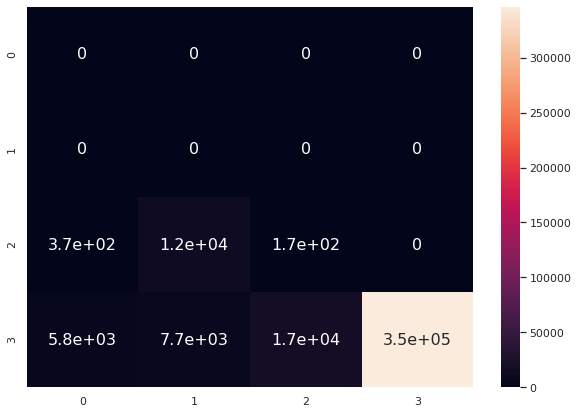

0.8901987486670864

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def get_network_test_accuracy_of(model):
    y_preds = np.argmax(model.predict(X_test_scaled), axis=-1)
    print('Test set length:', len(y_preds))
    print('First five predictions:\n', y_preds[0:5])
    matrix = confusion_matrix(y_preds, encoded_y_test)

    df_cm = pd.DataFrame(matrix, range(4), range(4))
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.0) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()

    return accuracy_score(y_preds, encoded_y_test)

encoded_y_test = encoder.transform(y_test)
print('Encoding of y_test:', encoded_y_test[0:5])
get_network_test_accuracy_of(model)